# Classifiers for What's Cooking

This file implements the following classifiers for the What's Cooking challenge, in an attempt to match the accuracy benchmarks noted below, from Ghewani-Raiyani (ref 1 in our brief):

**KNN** - 60.75% <br>
**Decision Tree** - 62.59% <br>
**Naive Bayes** - 73.25% <br>
**Random Forest** 74.13%  with an accuracy of the second paper claims accuracy of 76.2% using diff features. <br> 
**Logistic Regression** - 81.25% <br>
**SVM** - 81.32% <br>

Note that as labels for the test set are not available, the above benchmarks represent accuracy on the validation set. 

## Exec Summary

At present the analysis shows that even using a very simplistic pipeline featuring a CountVectorizer on the untransformed read-in data followed by un-tuned classifiers we can achieve results within 4ppts of the benchmarks, as tested on a single validation fold. 

## Further Work

1. I believe the greatest results will be achieved by improving the feature selection stage. At present the vectoriser selects individual words (so 'ground black pepper' would count towards each of the 'ground','black' and 'pepper' tokens) and there has been no modification done on the ingredients. Automated approaches could look at reducing number of features, concatenating, combining phrases with a high degree similarity etc. Manual approaches could look at ingredients appearing over a certian number of times and flag where these should be combined. Might be worth exploring the effects of combining the bin&cluster&count approach from the 2nd paper with a more effective classifier such as an SVM. - Fahad & Dave

2. To turn this into more of a data mining project, we should look at adding more features through blending in other data sets. There are several available which give nutritional information, with a greater or lesser amount of manual processing required. FooDB is also worth considering - it only contains around 700 raw food items, but contains detail on their chemical compositions, allowing us to impute some idea about a taste profile! Difficulties will likely be encountered in the fact that processed foods such as soy sauce are not included in this database, so raw composite ingredients will need to be considered and summed. Substantial manual work will likely be required if this approach is taken. - ON HOLD, TO ASSESS IMPACT.

3. There is still machine learning work to be done as well, the classifiers were only selected due to inclusion in the benchmark paper, and many others could be tried. Following selection, a degree of parameter turning will need to be performed by creating additional validation folds. Additionally, given indicators that some predictors are stronger on different cuisines, we may want to explore ways to ensemble these. Shree & Dave

4. We also need visualisations to showcase our results in the report. I have included some in this notebook, but we will likely need a wider range - these can be done in an external program if preferred. - Fahad, Mehmet, Shree

5. To address some of the DM requirements, there was also talk of scraping and blending in additional recipes. Cuisine labels for these may not be available but if not it may be possible to use these to improve the quality of features for prediction. - Mariam & Sina

### Section 1: Data Read-In

Effectively the same as in the andrew_bag_of_words file, except loads in the data directly as a dataframe rather than using json + transform.

In [1]:
import csv, os, pandas as pd, pathlib, pprint, json, numpy as np
import bagOfWords as bow
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Make sure json training json file exists

data_directory = os.path.join(os.getcwd(), "Dataset")
train_data_file_path = os.path.join(data_directory, "train.json")
test_data_file_path = os.path.join(data_directory, "test.json")
    
if(not pathlib.Path(train_data_file_path).is_file()):
    raise Exception("Missing train.json file in " + data_directory)

    
if(not pathlib.Path(test_data_file_path).is_file()):
    raise Exception("Missing test.json file in " + data_directory)

In [3]:
# Read JSON training data

with open(train_data_file_path, 'r') as f:
     trainData = pd.read_json(f)
f.closed

with open(test_data_file_path, 'r') as f:
     testData = pd.read_json(f)
f.closed

trainData.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


### Section 2: Analysis & Visualisation

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Visualising the recipe counts by cuisine.

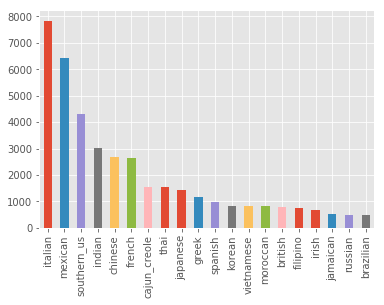

In [6]:
trainData['cuisine'].value_counts().plot(kind='bar')

Creating a table showing the 10 most common ingredients for each cuisine.

In [7]:
from collections import Counter

counters = {}
for cuisine in trainData['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (trainData['cuisine'] == cuisine)
    for ingredients in trainData[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [9]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


We can see from the above that the presence of salt tells us very little, but something like fish sauce can narrow down the probable cuisines considerably. To see how big this effect is, we visualise the percentage of recipes that our most common ingredients are found in, for each cuisine.

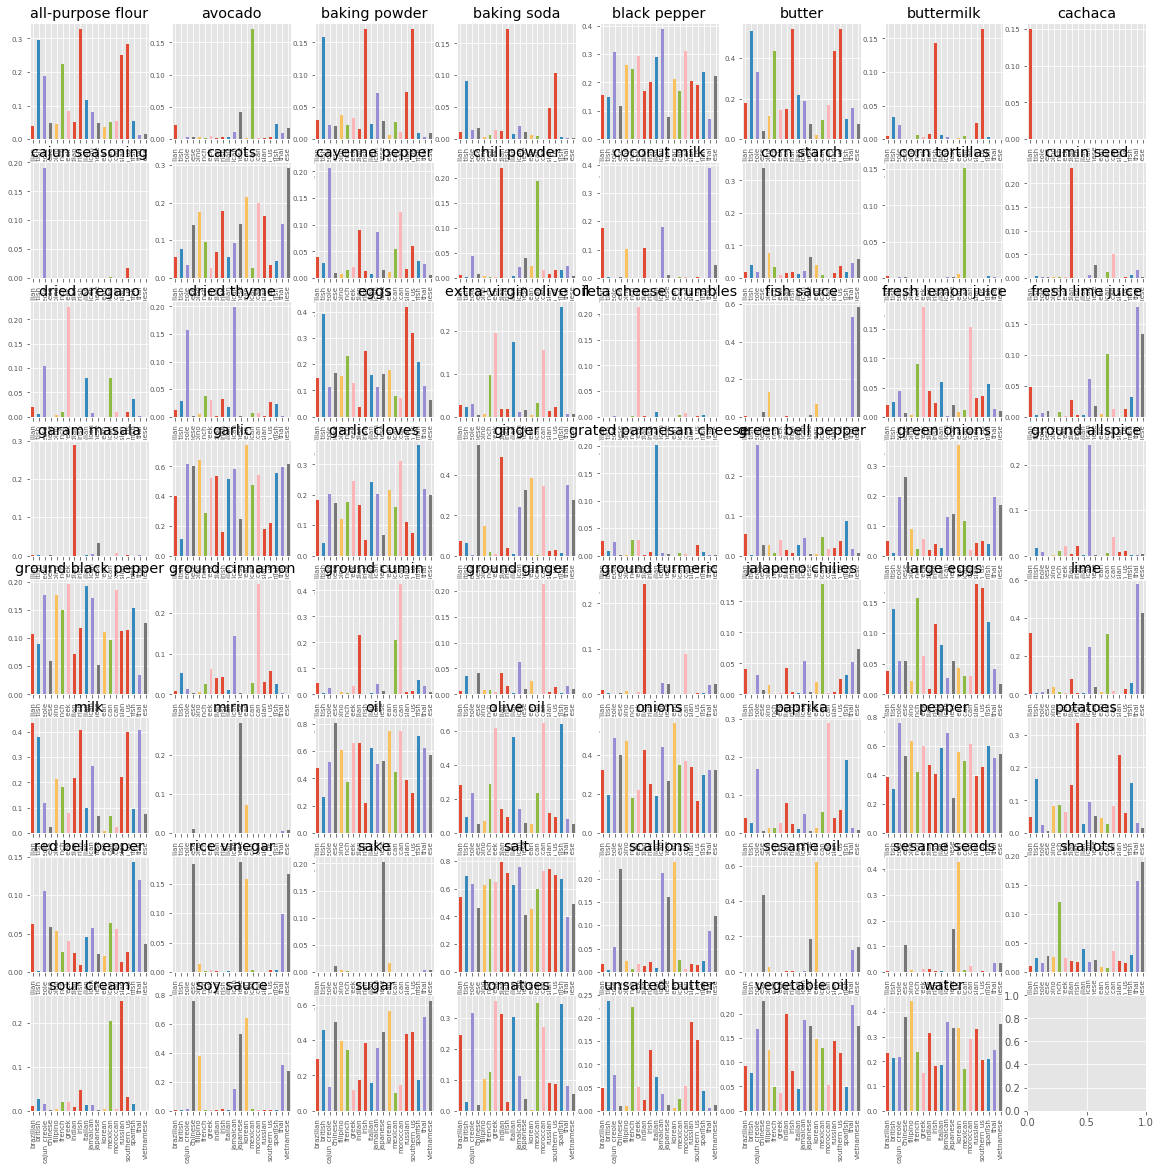

In [10]:
import numpy as np

unique = np.unique(top10.values.ravel())
trainData['all_ingredients'] = trainData['ingredients'].map(";".join)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = trainData['all_ingredients'].str.contains(ingredient)
    #indices = any(ingredient in s for s in trainData['ingredients'])
    relative_freq = (trainData[indices]['cuisine'].value_counts() / trainData['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)


This indicates the above statement in a more understandable form - ingredients like water, butter and oil don't do much to differentiate between cuisines, whereas sake, feta cheese and garam masala are exceptionally informative.

This is, perhaps, not too surprising, and does indicate that a Naive Bayes classifier should perform very well on this dataset. 

### Section 3: Classifier Implementation

On the single fold of data tested (seed=37), the six classifiers implemented below achieved the following accuracy. Benchmarks are shown in brackets:

**KNN** - 64.44% *(60.75)* <br>
**Decision Tree** - 63.78% *(62.59)* <br>
**Naive Bayes** - 72.57% *(73.25)* <br>
**Random Forest** - 71.16% *(74.13)* <br>
**Logistic Regression** - 78.37% *(81.25)* <br>
**SVM (LinearSVC)** - 77.05% *(81.32)* <br>

For reference, on the test set a score of 82.07% would have been sufficient for a Top-10 placement, while the competition winner scored 83.02%.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(trainData['all_ingredients'], trainData['cuisine'], test_size=0.2, random_state=37)

#### At this point we are splitting all of the ingredients into single words


In [12]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train.values)
X_test_vec = cv.transform(X_test.values)
X_train_vec.shape
#X_test_vec.shape

(31819, 2918)

In [13]:
X_test_vec.shape

(7955, 2918)

In [14]:
print(list(cv.vocabulary_.keys())[:100])

['tomato', 'sauce', 'ground', 'black', 'pepper', 'garlic', 'scallions', 'chipotles', 'in', 'adobo', 'avocado', 'dried', 'thyme', 'instant', 'white', 'rice', 'cilantro', 'leaves', 'coconut', 'milk', 'water', 'red', 'beans', 'chopped', 'celery', 'skinless', 'chicken', 'thighs', 'onions', 'lime', 'zest', 'juice', 'wedges', 'salt', 'carrots', 'coarse', 'fresh', 'mint', 'soy', 'freshly', 'clarified', 'butter', 'phyllo', 'dough', 'baby', 'spinach', 'flat', 'leaf', 'parsley', 'olive', 'oil', 'long', 'grain', 'solid', 'tuna', 'feta', 'cheese', 'crumbles', 'pinenuts', 'linguine', 'basil', 'extra', 'virgin', 'sun', 'tomatoes', 'sliced', 'olives', 'cloves', 'balsamic', 'vinegar', 'bell', 'bay', 'purple', 'onion', 'flakes', 'arugula', 'shelled', 'pistachios', 'sea', 'bacon', 'diced', 'artichoke', 'hearts', 'pitted', 'rosemary', 'boneless', 'breast', 'brown', 'sugar', 'flour', 'tortillas', 'whole', 'kernel', 'corn', 'drain', 'finely', 'salsa', 'shredded', 'monterey', 'jack']


The below encodes the labels, mapping brazilian:vietnamese -> 0:19

In [15]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y_train_vec = enc.fit_transform(y_train.values)
y_test_vec = enc.transform(y_test.values)
y_train_vec[:100]

array([10,  6,  9,  6,  9,  9, 13, 13,  9,  9,  9, 16, 17, 18,  9,  9,  5,
       13, 13, 16, 10, 13, 18, 10, 18,  9, 13, 16, 13,  7, 16,  7,  9, 14,
       13,  3, 13,  4, 16,  9,  7,  9,  4, 18, 13, 12, 13, 11,  9,  9, 14,
        9, 13,  6, 11,  6,  8, 13, 13,  5,  9, 16,  7, 13, 17,  5, 18,  9,
       16,  3,  5, 13, 13,  3,  9,  7,  3,  2,  7, 13,  9, 13, 16,  8, 16,
        9, 14, 11, 13,  9, 16,  2, 17, 13,  9,  7,  9, 11, 16,  9],
      dtype=int64)

Lastly it's worth checking our validation fold has a representative number of each cuisine in the set. We will of course perform later refolding and validation, but don't want to invalidate the results we'll be commenting on. The graph appears to be showing roughly the same proportions as present in the initial trainData set, so we can proceed.

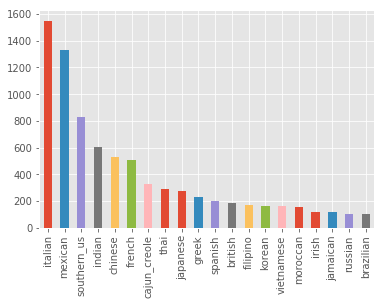

In [14]:
y_test.value_counts().plot(kind='bar')

#### Section 3.1: KNN Classifer

In [16]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(X_train_vec, y_train_vec)

neigh.score(X_test_vec, y_test_vec)

0.6443746071653048

#### This is a modification to the fit, using the original train set labels rather than label encoder


In [20]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(X_train_vec, y_train)

neigh.score(X_test_vec, y_test)

0.6443746071653048

In [23]:
#this is for the classification report y labels
cuisines = trainData['cuisine'].value_counts(sort=False).index
cuisines

Index(['chinese', 'korean', 'southern_us', 'mexican', 'italian', 'indian',
       'spanish', 'filipino', 'moroccan', 'russian', 'brazilian', 'greek',
       'cajun_creole', 'french', 'british', 'irish', 'japanese', 'jamaican',
       'thai', 'vietnamese'],
      dtype='object')

In [22]:
type(cuisines)

pandas.core.indexes.base.Index

In [37]:
#this is for the classification report y target_names
cuisineslist = cuisines.tolist()

In [25]:
neigh_pred = neigh.predict(X_test_vec)
print(classification_report(y_test, neigh_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.75      0.70      0.72       529
      korean       0.67      0.56      0.61       165
 southern_us       0.59      0.67      0.63       828
     mexican       0.77      0.84      0.80      1331
     italian       0.61      0.88      0.72      1550
      indian       0.76      0.71      0.73       605
     spanish       0.56      0.16      0.25       201
    filipino       0.53      0.61      0.56       171
    moroccan       0.73      0.36      0.48       152
     russian       0.64      0.07      0.12       104
   brazilian       0.45      0.38      0.41       102
       greek       0.70      0.41      0.52       229
cajun_creole       0.77      0.50      0.61       327
      french       0.40      0.47      0.44       508
     british       0.38      0.20      0.26       184
       irish       0.52      0.39      0.45       121
    japanese       0.52      0.55      0.53       276
    jamaican       0.91    

#### Section 3.2: Decision Tree Classifer

###### This is a modification to the original, using the y train and y test (cuisines) instead of the label encoded versions


In [33]:
from sklearn import tree

dec = tree.DecisionTreeClassifier()
dec.fit(X_train_vec, y_train)

dec.score(X_test_vec, y_test)

0.6451288497800126

In [34]:
dec_pred = dec.predict(X_test_vec)
print(classification_report(y_test, dec_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.69      0.70      0.70       529
      korean       0.62      0.64      0.63       165
 southern_us       0.59      0.63      0.61       828
     mexican       0.82      0.83      0.83      1331
     italian       0.72      0.77      0.74      1550
      indian       0.75      0.76      0.75       605
     spanish       0.36      0.36      0.36       201
    filipino       0.46      0.46      0.46       171
    moroccan       0.57      0.55      0.56       152
     russian       0.26      0.18      0.22       104
   brazilian       0.50      0.47      0.48       102
       greek       0.58      0.55      0.56       229
cajun_creole       0.60      0.55      0.58       327
      french       0.42      0.42      0.42       508
     british       0.36      0.26      0.30       184
       irish       0.38      0.34      0.36       121
    japanese       0.63      0.59      0.61       276
    jamaican       0.57    

Code courtesy of Stack Overflow - aim is to convert the above decision tree into a pythonic if-else statement so we can examine the decisions being made. Output is considerably too lengthy for easy reading, but we can see the low entropy of outputs at nearly all of the leaf nodes, indicating this tree is probably overfitting.

In [35]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [36]:
tree_to_code(dec,cv.get_feature_names())

def tree(10, 100, 14, 15, 25, 33, 40, 43, 95, 96, abalone, abbamele, absinthe, abura, acai, accent, achiote, acid, acini, ackee, acorn, acting, activ, active, added, adobo, adzuki, agar, agave, age, aged, ahi, ai, aioli, ajinomoto, ajwain, aka, alaskan, albacore, alcohol, ale, aleppo, alexia, alfalfa, alfredo, all, allspice, almond, almondmilk, almonds, aloe, alphabet, alum, amaranth, amaretti, amaretto, amba, amber, amberjack, amchur, america, american, aminos, ammonium, amontillado, ampalaya, an, anaheim, anasazi, ancho, anchovies, anchovy, and, andouille, anejo, angel, anglaise, angled, angostura, angus, anise, anisette, anjou, annatto, ao, aonori, apple, apples, applesauce, applewood, apricot, apricots, aquavit, arak, arame, arbol, arborio, arctic, arepa, arhar, armagnac, arrabbiata, arrow, arrowroot, artichok, artichoke, artichokes, artisan, arugula, asada, asadero, asafetida, asafoetida, ascorbic, asiago, asian, asparagus, aspic, assam, assorted, asti, atar, atta, au, avocado, av

                                                                                                                                                                                                                                            if eggs <= 0.5:
                                                                                                                                                                                                                                              return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 15.  0.
   0.  0.]]
                                                                                                                                                                                                                                            else:  # if eggs > 0.5
                                                                                                                                                              

                                                                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                            else:  # if gelatin > 0.5
                                                                                                                                                              if nonfat <= 0.5:
                                                                                                                                                                if pistachios <= 0.5:
                                                                                                                                                                  if strawberries <= 0.5:
                                         

                                                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0.]]
                                                                                                                                                else:  # if ground > 1.5
                                                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                          else:  # if confectioners > 0.5
                                                                                                                                            return [[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                

                                                                                                                                                                    return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                else:  # if juice > 0.5
                                                                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                                                                                                                                              else:  # if large > 0.5
                                                                                                                                                                if mil

                                                                                              else:  # if rutabaga > 0.5
                                                                                                return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                            else:  # if beef > 0.5
                                                                                              return [[0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                          else:  # if fresh > 0.5
                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:  # if onions > 0.5
                                          

                                                                                                    return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                else:  # if parsley > 0.5
                                                                                                  if black <= 0.5:
                                                                                                    return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                  else:  # if black > 0.5
                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                            else:  # if shrimp > 0.5
           

                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                    else:  # if coriander > 0.5
                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                                                  else:  # if beans > 0.5
                                                                    return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                else:  # if sea > 0.5
                                                                  if mango <= 0.5:
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                  else:  # if mango

                                                                              else:  # if cubes > 0.5
                                                                                if superfine <= 0.5:
                                                                                  if ale <= 0.5:
                                                                                    return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                  else:  # if ale > 0.5
                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                else:  # if superfine > 0.5
                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                         

                                                                                                                                    else:  # if oil > 0.5
                                                                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                                                                                                                else:  # if scallions > 0.5
                                                                                                                                  if low <= 0.5:
                                                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                  else:  

                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                      else:  # if sugar > 0.5
                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]]
                                                                                    else:  # if water > 0.5
                                                                                      if hot <= 0.5:
                                                                                        if sugar <= 1.5:
                                                                                          return [[0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:

                                                                                              if seasoning <= 0.5:
                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                              else:  # if seasoning > 0.5
                                                                                                return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:  # if chicken > 0.5
                                                                                          if lime <= 0.5:
                                                                                            if peas <= 0.5:
                                                                                              if salt

                                                                                    else:  # if cornmeal > 0.5
                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                  else:  # if sugars > 0.5
                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                                                else:  # if saffron > 0.5
                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]]
                                                                              else:  # if fresh > 0.5
                                                                                return [[0. 0. 0. 0. 0. 0. 0.

                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                      else:  # if yeast > 0.5
                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                                                    else:  # if cherry > 0.5
                                                                      return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                else:  # if soda > 0.5
                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0.]]
                                                            else:  # if cake > 0.5
                                                              return [[0. 2. 0.

                                            else:  # if corn > 1.5
                                              if salt <= 0.5:
                                                if seasoning <= 0.5:
                                                  return [[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                else:  # if seasoning > 0.5
                                                  return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if salt > 0.5
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 7. 0. 0. 0.]]
                                          else:  # if coconut > 0.5
                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0.]]
                                        else:  # if ricotta > 0.5
                                          retur

                                    return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                          else:  # if rice > 0.5
                            if peas <= 0.5:
                              if vinegar <= 0.5:
                                if of <= 0.5:
                                  if peanut <= 0.5:
                                    if carrots <= 0.5:
                                      if black <= 1.5:
                                        if honey <= 0.5:
                                          if large <= 1.5:
                                            if stuffing <= 0.5:
                                              if blend <= 0.5:
                                                if bacon <= 0.5:
                                                  if giblet <= 0.5:
                                                    if instant <= 0.5:
                                                      if collard <= 0.5:
                       

                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
                                                              else:  # if spinach > 0.5
                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                            else:  # if peach > 0.5
                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                          else:  # if peppercorns > 0.5
                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                                        else:  # if regular > 0.5
                                                          return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

                                                        if cooking <= 0.5:
                                                          return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. 55.]]
                                                        else:  # if cooking > 0.5
                                                          if jalapeno <= 0.5:
                                                            if thighs <= 0.5:
                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6.]]
                                                            else:  # if thighs > 0.5
                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                                          else:  # if jalapeno > 0.5
                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

                                                                                                                else:  # if less > 0.5
                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                              else:  # if flower > 0.5
                                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
                                                                                                          else:  # if cayenne > 0.5
                                                                                                            if garlic <= 0.5:
                                                                                                        

                                                                    if black <= 0.5:
                                                                      return [[0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                    else:  # if black > 0.5
                                                                      if cloves <= 0.5:
                                                                        return [[0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                      else:  # if cloves > 0.5
                                                                        if wine <= 0.5:
                                                                          return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                        else:  # if wine > 0.5
                            

                                                  return [[0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if large > 0.5
                                                if freshly <= 0.5:
                                                  return [[0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                else:  # if freshly > 0.5
                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if chicken > 1.5
                                              if olives <= 0.5:
                                                if sherry <= 0.5:
                                                  return [[0. 0. 0. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                else:  # if sherry > 0.5
                                

                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                    else:  # if dry > 0.5
                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                              else:  # if gruyere > 0.5
                                if pepper <= 0.5:
                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                else:  # if pepper > 0.5
                                  if linguine <= 0.5:
                                    return [[ 0.  0.  0.  0.  0. 13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]
                                  else:  # if linguine > 0.5
                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                            else:  # if manchego > 0.5
                              if arugula <= 0.5:
 

                                                              if mashed <= 0.5:
                                                                if pickled <= 0.5:
                                                                  if split <= 0.5:
                                                                    if flaxseed <= 0.5:
                                                                      if aged <= 0.5:
                                                                        if seafood <= 0.5:
                                                                          if turmeric <= 0.5:
                                                                            if flageolet <= 0.5:
                                                                              if tempeh <= 0.5:
                                                                                if grapefruit <= 0.5:
                                                                                  if coulis <= 0.5:


                                                                                                        if scallions <= 0.5:
                                                                                                          return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 41.  0.  0.  0.  0.
   0.  0.]]
                                                                                                        else:  # if scallions > 0.5
                                                                                                          if kernels <= 0.5:
                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                          else:  # if kernels > 0.5
                                                                                                            

                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                            else:  # if golden > 0.5
                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]]
                      else:  # if plain > 0.5
                        if dried <= 0.5:
                          if almonds <= 0.5:
                            if rotini <= 0.5:
                              return [[ 0.  0.  0.  0.  0.  0.  0. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]
                            else:  # if rotini > 0.5
                              return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                          else:  # if almonds > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
                        else:  # if dried > 0.5
                          if raisins <= 0.5:
                            return [[1. 0. 0

                      if powder <= 0.5:
                        if sugar <= 0.5:
                          if milk <= 0.5:
                            return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 11.  0.  0.  0.
   0.  0.]]
                          else:  # if milk > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                        else:  # if sugar > 0.5
                          if granulated <= 0.5:
                            return [[0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                          else:  # if granulated > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if powder > 0.5
                        if ground <= 5.5:
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                        else:  # if ground > 5.5
                        

                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                                        else:  # if stock > 0.5
                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                                                    else:  # if shallots > 0.5
                                                      if spray <= 0.5:
                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                                                      else:  # if spray > 0.5
                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                  else:  # if soba > 0.5
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0

                                                                                                                        return [[ 0.  0.  0. 31.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]
                                                                                                                    else:  # if oil > 0.5
                                                                                                                      return [[  0.   0.   0. 426.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]]
                                                                                                                  else:  # if cayenne > 0.5
                                                                                                                    if white <= 1.5:
                                                                                                                      return [[ 0.  0.  0. 13.  0

                                                                                                                                              if oil <= 0.5:
                                                                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                              else:  # if oil > 0.5
                                                                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                          else:  # if cannelloni > 0.5
                                                                                  

#### Section 3.3: Naive Bayes Classifer

###### This is a modification to the original, using the y train and y test (cuisines) instead of the label encoded versions


In [38]:
from sklearn.naive_bayes import MultinomialNB

bayes = MultinomialNB()
#todense() method used to coerce ndarray from csr (sparse) to dense format
#only seemed to be throwing errors on the training matrix, unsure why
bayes.fit(X_train_vec.todense(), y_train)

bayes.score(X_test_vec.todense(), y_test)

0.7257071024512884

In [40]:
bayes_pred = bayes.predict(X_test_vec.todense())
print(classification_report(y_test, bayes_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.74      0.87      0.80       529
      korean       0.80      0.73      0.77       165
 southern_us       0.56      0.73      0.63       828
     mexican       0.91      0.87      0.89      1331
     italian       0.83      0.79      0.81      1550
      indian       0.84      0.86      0.85       605
     spanish       0.52      0.50      0.51       201
    filipino       0.75      0.46      0.57       171
    moroccan       0.68      0.80      0.73       152
     russian       0.69      0.30      0.42       104
   brazilian       0.53      0.28      0.37       102
       greek       0.65      0.62      0.64       229
cajun_creole       0.60      0.77      0.67       327
      french       0.50      0.54      0.52       508
     british       0.35      0.33      0.34       184
       irish       0.56      0.39      0.46       121
    japanese       0.89      0.62      0.73       276
    jamaican       0.85    

#### Section 3.4: Random Forest Classifer

In [41]:
from sklearn.ensemble import RandomForestClassifier

frst = RandomForestClassifier(random_state=37)
frst.fit(X_train_vec, y_train)

frst.score(X_test_vec, y_test)

0.7116279069767442

In [42]:
frst_pred = frst.predict(X_test_vec)
print(classification_report(y_test, frst_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.68      0.84      0.75       529
      korean       0.79      0.59      0.67       165
 southern_us       0.67      0.67      0.67       828
     mexican       0.82      0.90      0.86      1331
     italian       0.71      0.89      0.79      1550
      indian       0.77      0.87      0.81       605
     spanish       0.71      0.26      0.38       201
    filipino       0.62      0.47      0.53       171
    moroccan       0.82      0.53      0.65       152
     russian       0.56      0.18      0.28       104
   brazilian       0.66      0.50      0.57       102
       greek       0.68      0.55      0.61       229
cajun_creole       0.70      0.66      0.68       327
      french       0.47      0.52      0.50       508
     british       0.48      0.29      0.36       184
       irish       0.57      0.34      0.42       121
    japanese       0.77      0.61      0.68       276
    jamaican       0.84    

#### Section 3.5: Logistic Regression Classifer

In [43]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_vec, y_train)

logistic.score(X_test_vec, y_test)

0.7836580766813325

Text(0.5,64.6,'Predicted label')

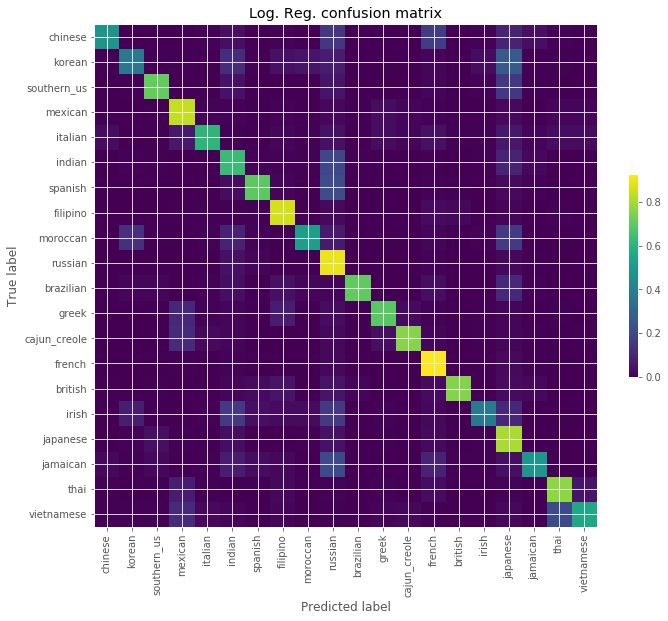

In [44]:
plt.figure(figsize=(10, 10))

log_cm = confusion_matrix(y_test, logistic.predict(X_test_vec))
log_cm_normalized = log_cm.astype('float') / log_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(log_cm_normalized, interpolation='nearest')
plt.title("Log. Reg. confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [45]:
log_pred = logistic.predict(X_test_vec)
print(classification_report(y_test, log_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.80      0.84      0.82       529
      korean       0.82      0.76      0.79       165
 southern_us       0.68      0.81      0.74       828
     mexican       0.90      0.93      0.91      1331
     italian       0.79      0.90      0.84      1550
      indian       0.87      0.87      0.87       605
     spanish       0.69      0.48      0.57       201
    filipino       0.77      0.61      0.68       171
    moroccan       0.86      0.76      0.80       152
     russian       0.60      0.38      0.46       104
   brazilian       0.73      0.48      0.58       102
       greek       0.78      0.69      0.73       229
cajun_creole       0.82      0.71      0.76       327
      french       0.59      0.63      0.61       508
     british       0.62      0.37      0.46       184
       irish       0.68      0.52      0.59       121
    japanese       0.82      0.69      0.75       276
    jamaican       0.91    

#### Note altered cuisines of concern

Although the raw accuracy score looks good, the confusion matrix and particularly the analysis of the recall show a different story for some cuisines. Spanish, Russian and British dishes are more likely to be classified as other cuisines than they are themselves, indicating that there may be few stand-out ingredients for these cuisines.

#### Section 3.6: SVM Classifer

In [47]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(random_state=37)
lsvc.fit(X_train_vec, y_train)

lsvc.score(X_test_vec, y_test)

0.7704588309239472

Text(0.5,64.6,'Predicted label')

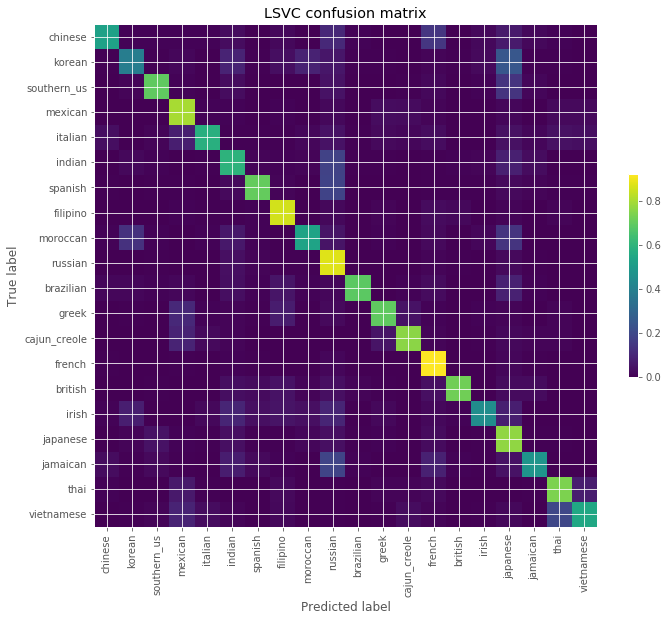

In [48]:
plt.figure(figsize=(10, 10))

lsvc_cm = confusion_matrix(y_test, lsvc.predict(X_test_vec))
lsvc_cm_normalized = lsvc_cm.astype('float') / lsvc_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(lsvc_cm_normalized, interpolation='nearest')
plt.title("LSVC confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [50]:
lsvc_pred = lsvc.predict(X_test_vec)
print(classification_report(y_test, lsvc_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.78      0.81      0.79       529
      korean       0.72      0.76      0.74       165
 southern_us       0.69      0.77      0.73       828
     mexican       0.90      0.92      0.91      1331
     italian       0.81      0.88      0.84      1550
      indian       0.86      0.86      0.86       605
     spanish       0.61      0.48      0.54       201
    filipino       0.76      0.58      0.66       171
    moroccan       0.76      0.72      0.74       152
     russian       0.56      0.45      0.50       104
   brazilian       0.61      0.53      0.57       102
       greek       0.73      0.71      0.72       229
cajun_creole       0.78      0.70      0.74       327
      french       0.61      0.60      0.60       508
     british       0.55      0.39      0.46       184
       irish       0.54      0.54      0.54       121
    japanese       0.77      0.70      0.73       276
    jamaican       0.80    

#### Bonus section: implementing pipelines from andrew_bag_of_words to compare results

In [55]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   n_iter=5,
                                                   random_state=42)),
                         ])

text_clf_svm.fit(X_train, y_train)
text_clf_svm.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.7063482086737901

In [183]:
pipe_svm_pred = text_clf_svm.predict(X_test)
print(classification_report(y_test, pipe_svm_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.75      0.26      0.39       102
     mexican       0.57      0.11      0.18       184
 southern_us       0.71      0.67      0.69       327
      indian       0.65      0.87      0.74       529
     chinese       0.82      0.23      0.36       171
      french       0.63      0.38      0.47       508
cajun_creole       0.76      0.54      0.63       229
        thai       0.74      0.89      0.81       605
    japanese       0.62      0.23      0.34       121
       greek       0.68      0.93      0.78      1550
     spanish       0.84      0.44      0.57       117
      korean       0.80      0.61      0.69       276
  vietnamese       0.76      0.45      0.57       165
    moroccan       0.82      0.93      0.87      1331
     british       0.80      0.49      0.60       152
    filipino       0.66      0.26      0.37       104
       irish       0.61      0.74      0.67       828
    jamaican       0.66    

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', OneVsRestClassifier(MultinomialNB()))])

pipe_nb.fit(X_train, y_train)
pipe_nb.score(X_test,y_test)

0.6764299182903835

In [56]:
pipe_nb_pred = pipe_nb.predict(X_test)
print(classification_report(y_test, pipe_nb_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.59      0.90      0.72       529
      korean       0.93      0.38      0.54       165
 southern_us       0.50      0.80      0.61       828
     mexican       0.80      0.92      0.86      1331
     italian       0.66      0.91      0.76      1550
      indian       0.76      0.90      0.83       605
     spanish       0.96      0.11      0.20       201
    filipino       0.95      0.11      0.20       171
    moroccan       0.96      0.34      0.50       152
     russian       1.00      0.02      0.04       104
   brazilian       1.00      0.19      0.31       102
       greek       0.89      0.33      0.48       229
cajun_creole       0.80      0.50      0.61       327
      french       0.53      0.42      0.47       508
     british       0.81      0.07      0.13       184
       irish       0.93      0.11      0.19       121
    japanese       0.94      0.57      0.71       276
    jamaican       0.95    

This is actually the most interesting result so far. The high precision and horrendous recall on Spanish, Filipino, British, Irish and Jamaican suggest that the classifier is barely predicting these cuisines at all. That said, the f-score is very high for other cuisines such as Mexican, Indian, Italian, Chinese, suggesting that this could be used as part of a One vs All classifier ensemble, specifically for dealing with those cuisines.

Text(0.5,64.6,'Predicted label')

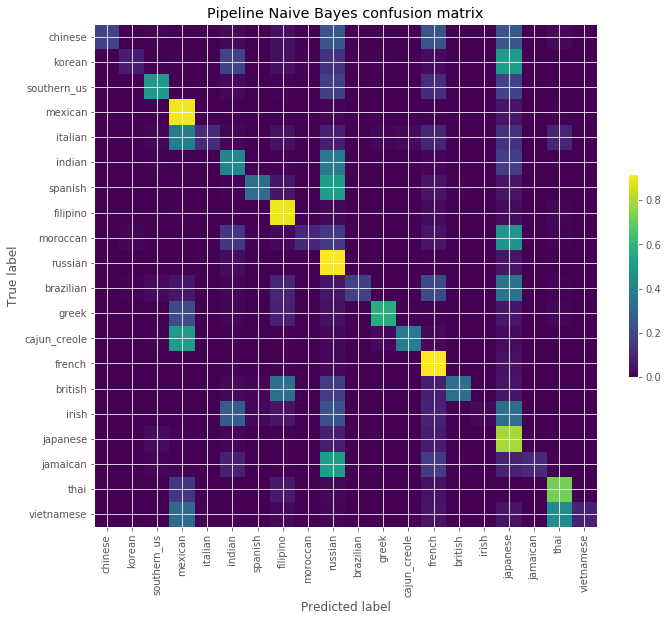

In [57]:
plt.figure(figsize=(10, 10))

pipe_nb_cm = confusion_matrix(y_test, pipe_nb.predict(X_test))
pipe_nb_cm_normalized = pipe_nb_cm.astype('float') / pipe_nb_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(pipe_nb_cm_normalized, interpolation='nearest')
plt.title("Pipeline Naive Bayes confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')